In [ ]:
# https://github.com/kurmukovai/ebm-progression
    
# https://github.com/EuroPOND/ebm
    
# https://github.com/ucl-pond/ebm
        
# https://github.com/88vikram/pyebm/

---

$$
\frac{a}{b+f*e^{(-x+c)/d}}
$$

- a - вытягивает/сжимает сигмоиду по оси OY (не нужен)
- b - сжимает/вытягивает сигмоиду по оси OY (не нужен)
- f - немного двигает по оси OX (хуже чем `c`, не нужен)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def sigmoid(x, a=1, b=1, c=0, d=1, f=1):
    return a / (b + f*np.exp((-x+c)/d))

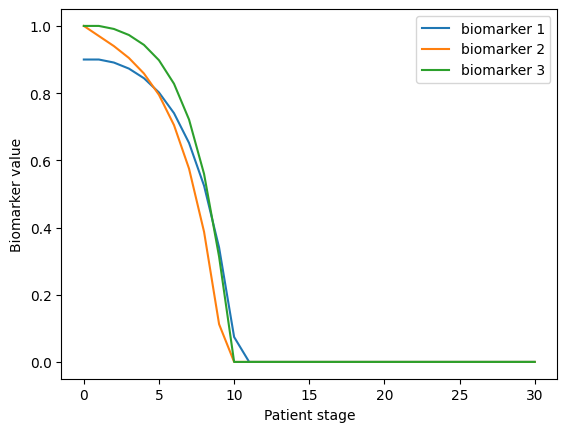

In [125]:
def generate_transition_matrix(a, size):
    A = np.eye(size)  # Start with an identity matrix
    for i in range(size - 1):
        A[i, i + 1] = A[i + 1, i] = a  # Set the off-diagonal elements
    return A

def apply_transition(A, y_init, n):
    y = 1 - y_init
    for _ in range(n):
        y = np.clip(A @ y, 0, 1)  # Apply transition and clip values
    return 1 - y

a = 0.3
matrix_size = 5
stages = np.arange(31)  # 0 to 30
initial_state = np.array([0.90, 1, 1, 1, 1], dtype=np.float32)

A = generate_transition_matrix(a, matrix_size)
biomarker_progressions = [apply_transition(A, initial_state, n) for n in stages]
for i in range(3):
    plt.plot(stages, [progression[i] for progression in biomarker_progressions], label=f'biomarker {i + 1}')

plt.xlabel('Patient stage')
plt.ylabel('Biomarker value')
plt.legend()
plt.show()

An event-based model for disease progression and its application in familial
Alzheimer's disease and Huntington's disease, Fonteijn et. al, 2012

[1] https://pure.mpg.de/rest/items/item_1313588/component/file_1402624/content

Model assumptions


1. All patients have the same order of biomarkers degeneration
2. Biomarkers degenerate monotonically (once degenerate - never recover)
3. A specific biomarker distribution could be modelled as:
    - mixture of gaussians (healthy, diseased)
    - mixture of gaussian and uniform
4. Degradation trajectory follows a sigmoid with individual (for every biomarker) parameters of shift and slope:


$$
y = 1 - \frac{1}{1+e^{-(x-\text{shift})/\text{slope}}}
$$

# 1. Basic model

Slope is constant for all biomarkers, different biomarkers have different shift. Thus one biomarker start degrading earlier than other/s.


$$
X_i = 1 - \frac{1}{1+e^{-(x-s_i)/c}}
$$


$i$ is biomarker index, $x$ is patient stage, $s_i$ indicates at what stage $i$'th biomarker is 50% abnormal, $X_i$ is a value of a biomarker (e.g. gyrus thickness).

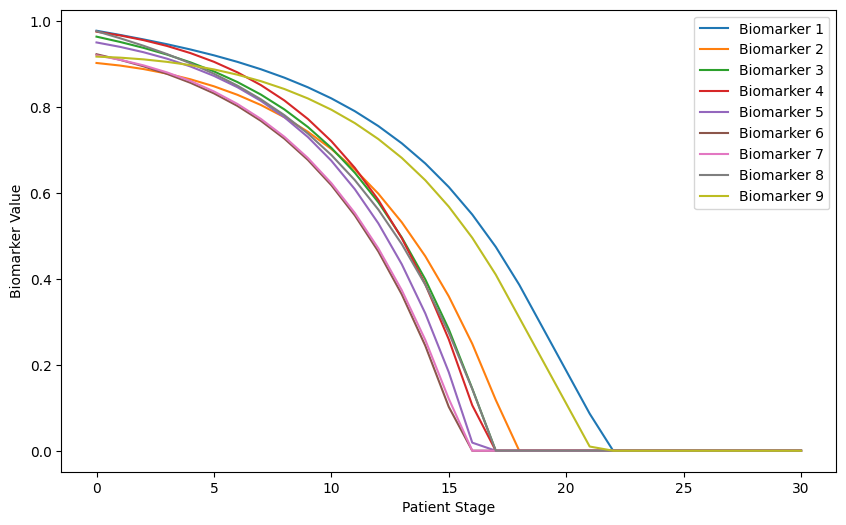

In [130]:
def sigmoid_inv(x, s=0):
    """Generates sigmoid with given shift parameter."""
    c = 1
    return 1 - 1 / (1 + np.exp(-(x-s))/c)

def transition_mat(A, n, y_init):
    y = 1 - y_init
    for i in range(n):
        y = np.clip(A @ y, 0, 1)
    return 1 - y

def generate_transition_matrix(size, coeff):
    """Generates a transition matrix where size is the number of biomarkers and decay coefficient."""
    A = np.eye(size)  # Identity matrix
    np.fill_diagonal(A[:-1, 1:], coeff)  # Fill right of the diagonal
    np.fill_diagonal(A[1:, :-1], coeff)  # Fill left of the diagonal
    return A.astype(np.float32)

def initialize_biomarkers(num_biomarkers, init_range=(0.9, 1.0), random_state=None):
    """Initializes biomarkers within a given range using a specified random state for reproducibility."""
    random = np.random.RandomState(random_state)
    return random.uniform(init_range[0], init_range[1], num_biomarkers).astype(np.float32)


def simulate_biomarkers(transition_matrix, y_init, stages):
    """Simulates the progression of biomarkers over given stages."""
    biomarkers = []
    for stage in stages:
        y = transition_mat(transition_matrix, stage, y_init)
        biomarkers.append(y)
    return np.array(biomarkers)


num_biomarkers = 9  # Number of biomarkers you want to simulate
coeff = 0.1  # Coefficient for the transition matrix
stages = np.linspace(0, 30, 31).astype(np.int32)  # Patient stages

# Generate transition matrix
A = generate_transition_matrix(num_biomarkers, coeff)
y_init = initialize_biomarkers(num_biomarkers, random_state=10)
biomarkers_progression = simulate_biomarkers(A, y_init, stages)

# Plotting (for a subset of biomarkers for clarity)
plt.figure(figsize=(10, 6))
for i in range(num_biomarkers):  # Plot first 3 biomarkers for clarity
    plt.plot(stages, biomarkers_progression[:, i], label=f'Biomarker {i+1}')
plt.xlabel('Patient Stage')
plt.ylabel('Biomarker Value')
plt.legend()
plt.show()


In [131]:
def generate_patient(stage, biomarkers: dict):
    """Generates vector of patient biomarkers given patient stage and dictionary of biomarkers' shifts."""
    x = []
    for marker, s in biomarkers.items():
        x.append(sigmoid_inv(stage, s))
    return np.array(x)

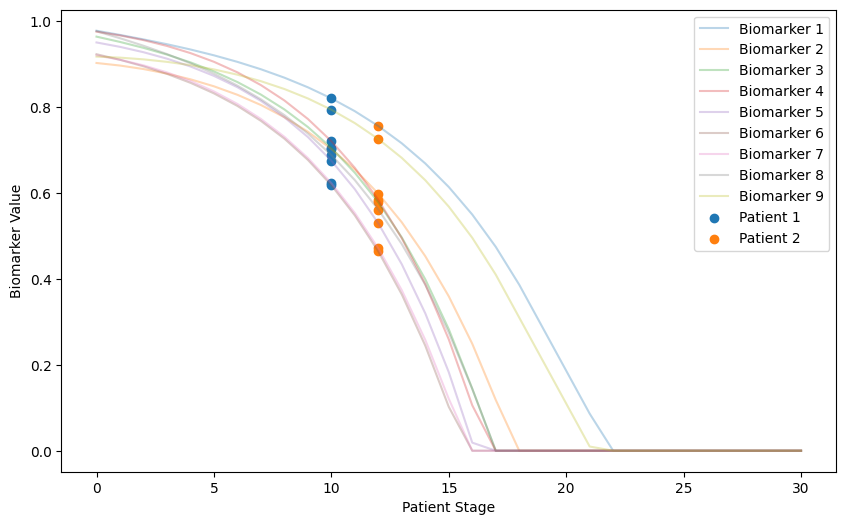

In [132]:
def generate_patient(stage, transition_matrix, y_init):
    """Generates vector of patient biomarkers given patient stage, transition matrix, and initial biomarker values."""
    y_stage = transition_mat(transition_matrix, stage, y_init)
    return y_stage

patient1_biomarkers = generate_patient(10, A, y_init)
patient2_biomarkers = generate_patient(12, A, y_init)

plt.figure(figsize=(10, 6))
for i in range(num_biomarkers): 
    plt.plot(stages, biomarkers_progression[:, i], label=f'Biomarker {i+1}', alpha=0.3)
plt.scatter([stage_example1] * num_biomarkers, patient1_biomarkers, label='Patient 1')
plt.scatter([stage_example2] * num_biomarkers, patient2_biomarkers, label='Patient 2')
plt.xlabel('Patient Stage')
plt.ylabel('Biomarker Value')
plt.legend()
plt.show()

# 2. Add noise


$$
X_i = 1 - \frac{1}{1+e^{-(x-s_i)/c}} + N(0, 0.1)
$$


In [71]:
def generate_patient(stage, biomarkers: dict, random_state=None):
    """Generates vector of patient biomarkers given patient
    stage and dictionary of biomarkers' shifts. Adds small noise (with fixed mu, std) to biomarkers."""
    
    random = np.random.RandomState(random_state)
    x = []
    for marker, s in biomarkers.items():
        value = sigmoid_inv(stage, s) + random.normal(0, 0.1)
        value = np.clip(value, 0, 1) # clip values to keep biomarkers' value bounded to [0,1]
        x.append(value)
    return np.array(x)



# noisy transition matrix version. 
def generate_patient(stage, transition_matrix, y_init, random_state=None):
    """Generates vector of patient biomarkers given patient
    stage and dictionary of biomarkers' shifts. Adds small noise (with fixed mu, std) to biomarkers."""
    
    random = np.random.RandomState(random_state)
    y_stage = transition_mat(transition_matrix, stage - 1, y_init) # stage zero correction "stage - 1"
    noise = random.normal(0, 0.1, y_stage.size)
    y_stage = y_stage + noise
    
    y_stage = np.clip(y_stage, 0, 1)
    
    return y_stage


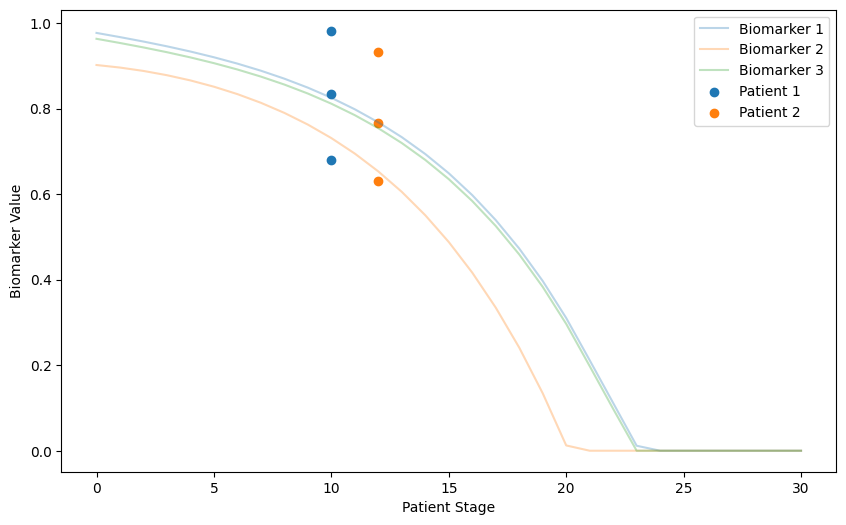

In [72]:
# Example usage with noise
patient1_biomarkers_noisy = generate_patient(stage_example1, A, y_init, random_state=10)
patient2_biomarkers_noisy = generate_patient(stage_example2, A, y_init, random_state=10)

# Plotting for visualization
plt.figure(figsize=(10, 6))
for i in range(num_biomarkers):  # Plotting all biomarkers for completeness
    plt.plot(stages, biomarkers_progression[:, i], label=f'Biomarker {i+1}', alpha=0.3)
plt.scatter([stage_example1] * num_biomarkers, patient1_biomarkers_noisy, label='Patient 1')
plt.scatter([stage_example2] * num_biomarkers, patient2_biomarkers_noisy, label='Patient 2')
plt.xlabel('Patient Stage')
plt.ylabel('Biomarker Value')
plt.legend()
plt.show()

# 3. Different degradation speed

$$
X_i = 1 - \frac{1}{1+e^{(-x+s_i)/c_i}} + N(0, 0.1)
$$


In [12]:
def sigmoid_inv(x, s=0, c=1):
    return 1 - 1 / (1 + np.exp(-(x-s)/c))


def generate_patient(stage, biomarkers: dict, random_state=None, noise=False):
    """Generates vector of patient biomarkers given patient
    stage and dictionary of biomarkers' shifts. Adds small noise (with fixed mu, std) to biomarkers."""
    random = np.random.RandomState(random_state)
    x = []
    for marker, parameters in biomarkers.items():
        value = sigmoid_inv(stage, parameters['s'], parameters['c'])
        if noise:
            value += random.normal(0, 0.1)
        value = np.clip(value, 0, 1)
        x.append(value)
    return np.array(x)

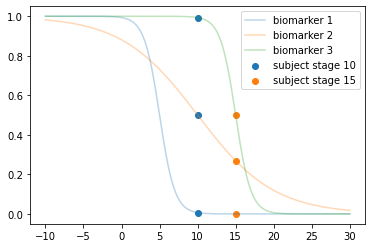

In [14]:
biomarkers = {
    1: {'s':5, 'c': 1},
    2: {'s':10, 'c': 5},
    3: {'s':15, 'c': 1}
}

x = np.linspace(-10, 30, 1000)
y1 = sigmoid_inv(x, 5, 1)
y2 = sigmoid_inv(x, 10, 5)
y3 = sigmoid_inv(x, 15, 1)

example1 = generate_patient(10, biomarkers, random_state=10)
example2 = generate_patient(15, biomarkers, random_state=10)

plt.plot(x, y1, label='biomarker 1', alpha=0.3)
plt.plot(x, y2, label='biomarker 2', alpha=0.3)
plt.plot(x, y3, label='biomarker 3', alpha=0.3)
plt.scatter([10]*3, example1, label='subject stage 10')
plt.scatter([15]*3, example2, label='subject stage 15')
plt.legend();

# 4. Change shifts from stage i to stage (i+1)

In all previous examples biomarkers always shift 5 from $i$ to $(i+1)$, let's remove this restriction

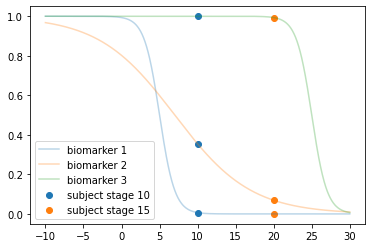

In [16]:
d = {
    1: {'s':5, 'c': 1},
    2: {'s':7, 'c': 5},
    3: {'s':25, 'c': 1}
}

x = np.linspace(-10, 30, 1000)
y1 = sigmoid_inv(x, d[1]['s'], d[1]['c'])
y2 = sigmoid_inv(x, d[2]['s'], d[2]['c'])
y3 = sigmoid_inv(x, d[3]['s'], d[3]['c'])

example1 = generate_patient(10, d, random_state=10)
example2 = generate_patient(20, d, random_state=10)

plt.plot(x, y1, label='biomarker 1', alpha=0.3)
plt.plot(x, y2, label='biomarker 2', alpha=0.3)
plt.plot(x, y3, label='biomarker 3', alpha=0.3)
plt.scatter([10]*3, example1, label='subject stage 10')
plt.scatter([20]*3, example2, label='subject stage 15')
plt.legend();

# Simulations


Keep in mind that for now we model a "canonical order" as a order of shifts, e.g. if biomarker $i$ has shift $5$ and biomarker $j$ has shift $10$, then in "canonical order" $i$ preceeds $j$. However, given different (possibly randomly generated values of shifts and slopes), some biomarker might have smaller shift, but degrade much faster after 50% threshold.

See example below, biomarker 2 starts degradion later than biomarker 1, but much faster.

In [18]:
random_state = 10

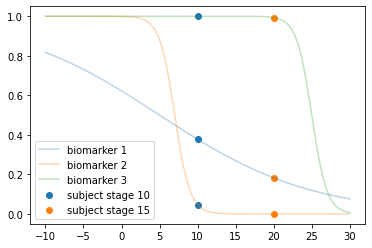

In [19]:
d = {
    1: {'s':5, 'c': 10},
    2: {'s':7, 'c': 1},
    3: {'s':25, 'c': 1}
}

x = np.linspace(-10, 30, 1000)
y1 = sigmoid_inv(x, d[1]['s'], d[1]['c'])
y2 = sigmoid_inv(x, d[2]['s'], d[2]['c'])
y3 = sigmoid_inv(x, d[3]['s'], d[3]['c'])

example1 = generate_patient(10, d, random_state)
example2 = generate_patient(20, d, random_state)

plt.plot(x, y1, label='biomarker 1', alpha=0.3)
plt.plot(x, y2, label='biomarker 2', alpha=0.3)
plt.plot(x, y3, label='biomarker 3', alpha=0.3)
plt.scatter([10]*3, example1, label='subject stage 10')
plt.scatter([20]*3, example2, label='subject stage 15')
plt.legend();

## Generate biomarker parameters

In [78]:
# random = np.random.RandomState(10) # fix RS for reproducibility

# shift = random.randint(5, 7, 11) # shifts are from 5 to 7, we generate 11 biomarkers
# shift = np.cumsum(shift)
# vel = random.randint(2, 15, 11) # degradation slope (velocity) is from 2 to 15, again 11 parameters

# x = np.linspace(-50, 120, 1000) # Rather arbitrary mapping from x to stage (uniform), works for now
# for s, v in zip(shift, vel):
#     yy = sigmoid_inv(x, s, v)
#     plt.plot(x, yy, alpha=0.1, c='b')

# plt.xticks(ticks=np.arange(-50,121,17), labels=np.arange(11));

# stage2x_dict = dict(zip(np.arange(11),np.arange(-50,121,17)))
# biomarkers_params = {}
# for i, (s, v) in enumerate(zip(shift, vel)):
#     biomarkers_params[i]={'s':s, 'c':v}
    
# plt.xlabel('Patient stage')
# plt.ylabel('Biomarker value');


# Define the transition matrix and initial biomarker values for each biomarker
A = generate_transition_matrix(size=11, coeff=0.1) 
biomarkers_initial = initialize_biomarkers(11, init_range=(0.9, 1.0), random_state=10) 

biomarkers_params = {
    'transition_matrix': A,
    'y_init': biomarkers_initial
}

In [79]:
biomarkers_params

{'transition_matrix': array([[1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. , 0.1],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 1. ]],
       dtype=float32),
 'y_init': array([0.9771321 , 0.9020752 , 0.96336484, 0.9748804 , 0.9498507 ,
        0.9224797 , 0.9198063 , 0.97605306, 0.91691107, 0.908834  ,
        0.96853596], dtype=float32)}

## Generate patient distribution (by stage)

How many patients will be at stage $x$

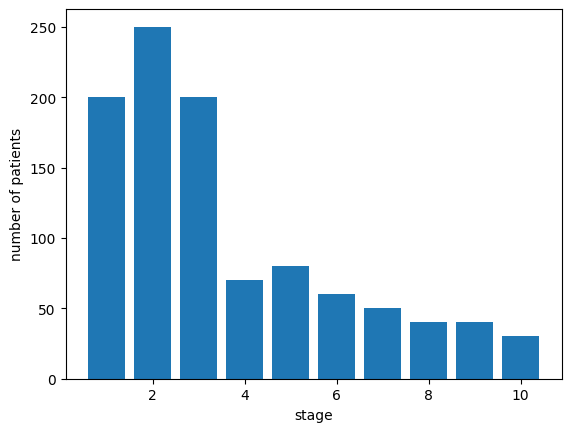

In [80]:
n_patients_stage = {
    1: 200,
    2: 250,
    3: 200,
    4: 70,
    5: 80,
    6: 60,
    7: 50,
    8: 40,
    9: 40,
    10: 30,
}

plt.bar(n_patients_stage.keys(), n_patients_stage.values());
plt.xlabel('stage')
plt.ylabel('number of patients');

## Generate biomarkers

In [74]:
def generate_patient(stage, transition_matrix, y_init, random_state=None):
    """Generates vector of patient biomarkers given patient
    stage and dictionary of biomarkers' shifts. Adds small noise (with fixed mu, std) to biomarkers."""
    
    random = np.random.RandomState(random_state)
    y_stage = transition_mat(transition_matrix, stage - 1, y_init) # stage zero correction "stage - 1"
    noise = random.normal(0, 0.1, y_stage.size)
    y_stage = y_stage + noise
    
    y_stage = np.clip(y_stage, 0, 1)
    
    return y_stage

In [88]:
# X = []
# rs = 0
# for stage, total_number in n_patients_stage.items():
#     for _ in range(total_number):
#         x = generate_patient(stage2x_dict[stage], biomarkers_params, noise=True, random_state=rs)
#         X.append(x)
#         rs+=1
        
# X = np.array(X)

# # Let's say stages 1,2,3 are normal, and stages > 3 are abnormal
# n_healthy = n_patients_stage[1]+n_patients_stage[2]+n_patients_stage[3]
# n_diseased = sum(n_patients_stage.values()) - n_healthy

# y = np.array([0]*n_healthy+[1]*n_diseased)


X = []
rs = 10  # Starting random state
for stage, total_number in n_patients_stage.items():
    for _ in range(total_number):
        patient_biomarkers = generate_patient(stage2x_dict[stage], biomarkers_params['transition_matrix'], biomarkers_params['y_init'], random_state=rs)
        X.append(patient_biomarkers)
        rs += 1  # Increment random state for variability
        
X = np.array(X)

n_healthy = n_patients_stage[1] + n_patients_stage[2] + n_patients_stage[3]
n_diseased = sum(n_patients_stage.values()) - n_healthy

y = np.array([0]*n_healthy + [1]*n_diseased)

In [89]:
X.shape, y.shape

((1020, 11), (1020,))

In [90]:
stages = []

for k,v in n_patients_stage.items():
    stages.extend([k]*v)
stages = np.array(stages)

In [91]:
stages

array([ 1,  1,  1, ..., 10, 10, 10])

In [121]:
# x = np.linspace(-50, 120, 1000) # Rather arbitrary mapping from x to stage (uniform), works for now
# for s, v in zip(shift, vel):
#     yy = sigmoid_inv(x, s, v)
#     plt.plot(x, yy, alpha=0.1, c='b')

# plt.xticks(ticks=np.arange(-50,121,17), labels=np.arange(11));

# stage2x_dict = dict(zip(np.arange(11),np.arange(-50,121,17)))
# biomarkers = {}
# for i, (s, v) in enumerate(zip(shift, vel)):
#     biomarkers[i]={'s':s, 'c':v}
    
# # Plot couple of example patients on biomarkers' trajectory

# plt.scatter([stages[150]]*11, X[150], )
    
# plt.xlabel('Patient stage')
# plt.ylabel('Biomarker value');

In [29]:
stages[150]

1

 Recall how even though stage is 1, on OX axis it apears as 3, this is due to shift for biomarker 0 being 6, see biomarkers_params dict, one could imporve this alignment, by generating sigmoids parameters in some systematic  non random way

In [30]:
biomarkers_params

{0: {'s': 6, 'c': 3},
 1: {'s': 12, 'c': 12},
 2: {'s': 17, 'c': 10},
 3: {'s': 23, 'c': 11},
 4: {'s': 28, 'c': 2},
 5: {'s': 34, 'c': 12},
 6: {'s': 40, 'c': 10},
 7: {'s': 45, 'c': 8},
 8: {'s': 51, 'c': 6},
 9: {'s': 57, 'c': 5},
 10: {'s': 62, 'c': 2}}

## Check biomarker's distribution

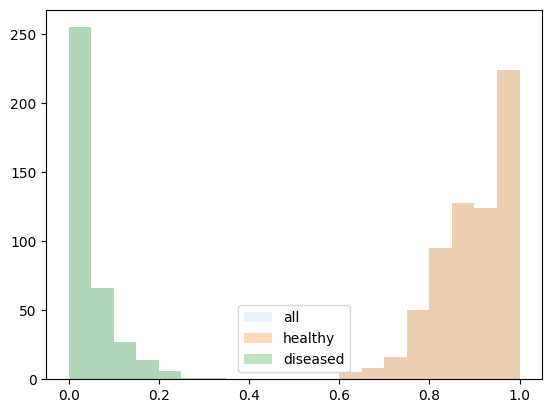

In [96]:
biomarker = 3

bins = plt.hist(X[:, biomarker], alpha=0.1, label='all', bins=20);
plt.hist(X[:n_healthy, biomarker], label='healthy', bins=bins[1], alpha=0.3);
plt.hist(X[n_healthy:, biomarker], label='diseased', bins=bins[1], alpha=0.3);
plt.legend();

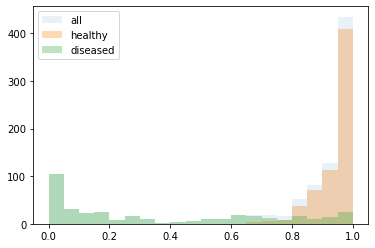

In [32]:
biomarker = 6

bins = plt.hist(X[:, biomarker], alpha=0.1, label='all', bins=20);
plt.hist(X[:n_healthy, biomarker], label='healthy', bins=bins[1], alpha=0.3);
plt.hist(X[n_healthy:, biomarker], label='diseased', bins=bins[1], alpha=0.3);
plt.legend();

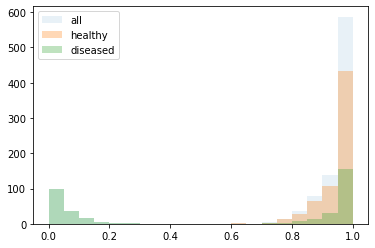

In [33]:
biomarker = 10

bins = plt.hist(X[:, biomarker], alpha=0.1, label='all', bins=20);
plt.hist(X[:n_healthy, biomarker], label='healthy', bins=bins[1], alpha=0.3);
plt.hist(X[n_healthy:, biomarker], label='diseased', bins=bins[1], alpha=0.3);
plt.legend();

In [93]:
X.shape

(1020, 11)

In [94]:
len(y)

1020

## Distribution of a noisy biomarker

stage 5, biomarker 7

In [98]:
# random = np.random.RandomState(10)

# shift = random.randint(5, 7, 11)
# shift = np.cumsum(shift)
# vel = random.randint(2, 15, 11)

# x = np.linspace(-50, 120, 1000)
# for s, v in zip(shift, vel):
#     yy = sigmoid_inv(x, s, v)
#     plt.plot(x, yy, alpha=0.1, c='b')
    
# yy = sigmoid_inv(x, shift[6], vel[6], )
# plt.plot(x, yy, alpha=0.7, c='b', label='biomarker 7')
# plt.scatter(x[500], yy[500], label='stage 5, no noise') # x[500]~=35~=stage 5
# plt.xticks(ticks=np.arange(-50,121,17), labels=np.arange(11));
# plt.hlines(0.6, -50, 80, ls='--')
# plt.legend();


# plt.figure()
# plt.hist(X[720:800, 6], 5, alpha=0.5) # stage 5
# plt.vlines(0.6, 0, 30, ls='--');

## EBM fit

install https://github.com/kurmukovai/ebm-progression by cloning the repo and `pip install -e .`

In [104]:
from ebm.probability import log_distributions, fit_distributions
from ebm.mcmc import greedy_ascent, mcmc
from ebm.likelihood import EventProbabilities

In [105]:
log_p_e, log_p_not_e = log_distributions(X, y, point_proba=False)

In [106]:
starting_order = np.arange(11)
# just to make optimization procedure do the job, since data where generated with canonical order 0..10
np.random.shuffle(starting_order) 
order, loglike, update_iters = greedy_ascent(log_p_e, log_p_not_e, 
                                             n_iter=10_000, order = starting_order,
                                             random_state=2020)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 6831.09it/s]


In [107]:
# almost correct, good job
order

array([ 2,  6,  4,  7,  1,  8,  5,  3,  9, 10,  0])

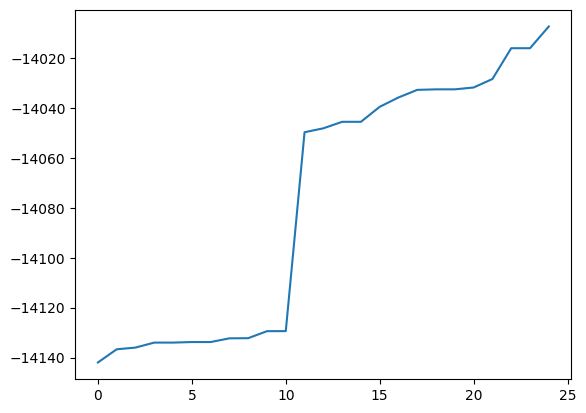

In [108]:
plt.plot(loglike)

In [109]:
orders, loglike, update_iters, probas = mcmc(log_p_e, log_p_not_e,
                                                 order=order, n_iter=500_000,
                                                 random_state=2020)

100%|██████████| 500000/500000 [01:15<00:00, 6590.69it/s]


In [110]:
orders[:10]

[array([ 2,  6,  4,  7,  1,  8,  5,  9,  3, 10,  0]),
 array([ 2,  6,  4,  7,  1,  8,  5, 10,  3,  9,  0]),
 array([ 2,  6,  4,  7,  1,  8,  3, 10,  5,  9,  0]),
 array([ 2,  6,  4,  7,  1,  8,  3,  5, 10,  9,  0]),
 array([ 2,  6,  4,  7,  1,  8, 10,  5,  3,  9,  0]),
 array([ 2,  6,  4,  7,  1,  8,  9,  5,  3, 10,  0]),
 array([ 2,  6,  4,  7,  1,  8,  9,  5, 10,  3,  0]),
 array([ 2,  6,  4,  7,  1,  8,  5,  9, 10,  3,  0]),
 array([ 2,  6,  4,  7,  1,  8,  5,  9,  3, 10,  0]),
 array([ 2,  6,  4,  7,  1,  8,  5,  9, 10,  3,  0])]

## Optimal order

For relatively small number of biomarkers, one could find an optimal order given the data (by computing all possible permutations). For 11 biomarkers, there are 11! = $39916800$ possible orders, so my implementation computing the total likelihood from Fontejn et. al takes about an 1 hour. One could optimize, I believe optimal order (under EBM setting) could be computationally tractable for ~15 biomarkers (in under a 1 day of computing+we could compute likelihoods in parallel, may be pushing to 16-17 biomarkers).

In [111]:
from tqdm import tqdm

In [112]:
model = EventProbabilities(log_p_e, log_p_not_e)
loglike = model.compute_total_likelihood(order)

In [113]:
import itertools
all_orders = list(itertools.permutations(np.arange(11)))

In [114]:
loglikes = []
for o in tqdm(all_orders):
    loglike = model.compute_total_likelihood(o)
    loglikes.append(loglike)

  0%|          | 0/39916800 [00:00<?, ?it/s]

100%|██████████| 39916800/39916800 [12:58:36<00:00, 854.45it/s]     


In [115]:
np.argmax(loglike)

0

In [116]:
all_orders[np.argmax(loglike)]

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [117]:
for i,o in enumerate(all_orders):
    if o == (1,  0,  2,  3,  5,  6,  4,  7,  8,  9, 10):
        print(i)
        break

3629640


In [118]:
loglikes[3629640]

-14164.6079055177

In [119]:
loglikes[0]

-14159.367247743947

In [120]:
np.min(loglikes)

-14209.364509118426

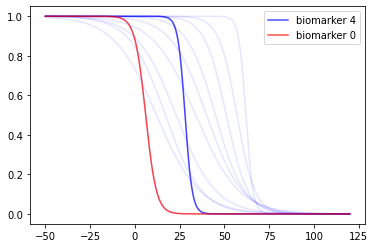

In [54]:
random = np.random.RandomState(10)

shift = random.randint(5, 7, 11)
shift = np.cumsum(shift)
vel = random.randint(2, 15, 11)

x = np.linspace(-50, 120, 1000)
for s, v in zip(shift, vel):
    yy = sigmoid_inv(x, s, v)
    plt.plot(x, yy, alpha=0.1, c='b')
    
yy = sigmoid_inv(x, shift[4], vel[4], )
plt.plot(x, yy, alpha=0.7, c='b', label='biomarker 4')
yy = sigmoid_inv(x, shift[0], vel[0], )

plt.plot(x, yy, alpha=0.7, c='r', label='biomarker 0')


plt.legend();

TODO: 

1. Добавить кластеры сабджектов
2. Придумать модель которая умеет такое фитить
3. Сделать принадлежность кластеру функцией от каких-то клинических переменных
 - MOCA
 - MMSE
 - UPDRS
 
 т.е условно скоры по MOCA определяет то в какой кластер деградации попадает пациент
 

одна группа маркеров которая генерит центры кластеров по клиническим переменным, потом в зависимости от кластера 
разные параметры сигмоид, 

модель для определения кластера может быть supervised 